<h2>Retrieval-Augmented Generation (RAG) - Using OpenAI and LangChain</h2>
 combines two fundamental approaches in natural language processing: generation and retrieval. Here's how it typically works:

 ![image-2.png](attachment:image-2.png)

1. **Retrieval Component**: The system has access to a database or a large repository of structured or unstructured data. This database contains information relevant to the task at hand, such as facts, knowledge, or contextual information.

2. **Retrieval Process**: When presented with a query or prompt, the system first retrieves relevant information from the database using retrieval techniques. This retrieval can involve various methods such as keyword matching, semantic similarity, or more advanced algorithms like dense retrieval using neural networks.

3. **Generation Component**: After retrieving relevant information, the system then utilizes a generative language model (such as GPT) to generate a response or complete the task. This generative component is responsible for producing natural language text based on the input query and retrieved information.

4. **Integration**: The retrieved information is integrated into the generation process, influencing the content and structure of the generated response. This integration can occur at different levels, from simple concatenation of retrieved passages to more sophisticated methods that selectively incorporate relevant information while generating the response.

5. **Output**: The final output is a response that combines both generated text and retrieved information, tailored to address the input query or task. The integration of retrieval and generation allows the system to leverage external knowledge sources to produce more accurate, coherent, and contextually relevant responses.

Overall, RAG models enable more informed and contextually rich interactions by leveraging both generative capabilities and access to external knowledge sources. They are particularly useful in tasks that require access to domain-specific knowledge or where context plays a crucial role in generating accurate responses.

Let's begin by initializing the environment variables required for use.
- pip install python-dotenv

In [21]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("API Key")

# This is the YouTube video we're going to use.
YOUTUBE_VIDEO = "https://www.youtube.com/watch?v=cdiD-9MMpb0"


Let's establish the model configuration for our workflow. We'll define the Large Language Model (LLM) that we'll utilize.
 - pip install langchain_openai


In [22]:
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

<p>Transforming the model's output into an AIMessage instance containing the answer involves a process known as chaining. Here's an illustration of how this chaining is typically executed:</p>
<p><strong>1. Model Output:</strong> After feeding input to the model, it generates a response. This response may be in raw form, such as a string of text.</p>
<p>2. Output Parser: The output parser is a component designed to interpret and extract meaningful information from the model's response. It analyzes the model's output and structures it into a structured format, such as an AIMessage instance.</p>
<p>3. AIMessage Instance: The AIMessage instance encapsulates the extracted information from the model's output in a format that's convenient for further processing or presentation. It might contain attributes like the answer to a question, metadata, or any other relevant details.</p>
<p>By chaining the model with an output parser, you can seamlessly convert the raw output into a structured format that's easier to work with and understand.</p>

In [5]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

chain = model | parser
chain.invoke("What is prompt enginnering?")

'Prompt engineering is the process of designing and developing prompts or cues that are used to trigger specific behaviors, actions, or responses in individuals. This can be done in a variety of contexts, such as in user interfaces for software applications, in educational settings to guide learning, or in marketing to influence consumer behavior. The goal of prompt engineering is to create prompts that are clear, effective, and persuasive in achieving the desired outcome.'

<h3><strong>Prompt Templates</strong></h3>
<p>We aim to furnish the model with both context and a question. Prompt templates offer a straightforward method for specifying and reusing prompts.<span style="color: rgb(226, 80, 65);"> <a href="https://python.langchain.com/docs/modules/model_io/prompts/quick_start" style="text-align: left;color: var(--jp-content-link-color);background-color: rgb(255, 255, 255);font-size: 14px;">Prompt templates</a></span></p>

In [7]:
from langchain.prompts import ChatPromptTemplate

template = """
Answer the question based on the context below. If you can't 
answer the question, reply "Sorry, I don't know".

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt.format(context="India is fifth largest GDP", question="What is India's rank in terms of global GDP?")

'Human: \nAnswer the question based on the context below. If you can\'t \nanswer the question, reply "Sorry, I don\'t know".\n\nContext: India is fifth largest GDP\n\nQuestion: What is India\'s rank in terms of global GDP?\n'

We're now able to link the prompt with both the model and the output parser, allowing for a seamless process.

In [9]:
chain = prompt | model | parser
chain.invoke({
    "context": "India is fifth largest GDP",
    "question": "What is India's rank in terms of global GDP?"
})

'India is ranked fifth in terms of global GDP.'

<h2><strong>Large Text &nbsp;As Context</strong></h2>
<p>With the integration of the prompt, model, and output parser, users can streamline their workflow by seamlessly connecting large context, &nbsp;result interpretation. This cohesive system enhances efficiency and accuracy in processing information. Lets keep our information in text file for now and we will pass as context to chain.&nbsp;</p>

In [10]:
with open("data.txt") as file:
    transcription = file.read()

transcription[:100]

"I think it's possible that physics has exploits and we should be trying to find them. arranging some"

Lets ask our question to large context 

In [13]:
try:
    chain.invoke({
        "context": transcription,
        "question": "What are some of the diverse landscapes mentioned in the description of India?"
    })
except Exception as e:
    print(e)

Error code: 429 - {'error': {'message': 'Request too large for gpt-3.5-turbo in organization org-O7gVNem5mEx5mWawyOL6I1O5 on tokens per min (TPM): Limit 40000, Requested 54019. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


<h4>Output</h4>

Error code: 429 - {'error': {'message': 'Request too large for gpt-3.5-turbo in organization org-O7gVNem5mEx5mWawyOL6I1O5 on tokens per min (TPM): Limit 40000, Requested 54019. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

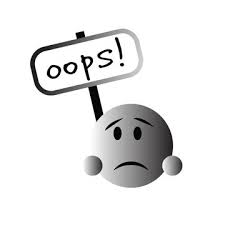

<h5> What is solution  -> Splitting the transcription</h5>
<p>Given that we're unable to employ the full text as context for the model, one approach is to divide the text into smaller segments. This segmentation enables us to call upon the model using solely the pertinent segments to address specific inquiries.</p>

Let's start by loading the text in memory:




In [14]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("data.txt")
text_documents = loader.load()
text_documents

[Document(page_content='Certainly! Here\'s a larger response regarding India:\nIndia, officially known as the Republic of India, is a country located in South Asia. It is the seventh-largest country by land area and the second-most populous country in the world, with over 1.3 billion people. India shares its borders with Pakistan to the northwest, China and Nepal to the north, Bhutan to the northeast, and Bangladesh and Myanmar to the east. The Indian Ocean lies to the south of India.\nIndia has a rich and diverse cultural heritage that dates back thousands of years. It has been home to several ancient civilizations and has been a major center for trade and commerce since ancient times. The Indian subcontinent has seen the rise and fall of many empires and dynasties, including the Maurya, Gupta, Mughal, and British empires.\nIn modern times, India is known for its vibrant democracy, diverse culture, and rapidly growing economy. It is a federal parliamentary democratic republic, with a 

<p>There are various methods to divide a document. In this instance, we'll employ a basic splitter that segments the document into fixed-size chunks. For demonstration, we'll split the transcription into segments of 500 characters with a 10-character overlap and exhibit the initial segments.</p>

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=10)
text_splitter.split_documents(text_documents)

[Document(page_content="Certainly! Here's a larger response regarding India:\nIndia, officially known as the Republic of India, is a country located in South Asia. It is the seventh-largest country by land area and the second-most populous country in the world, with over 1.3 billion people. India shares its borders with Pakistan to the northwest, China and Nepal to the north, Bhutan to the northeast, and Bangladesh and Myanmar to the east. The Indian Ocean lies to the south of India.", metadata={'source': 'data.txt'}),
 Document(page_content='India has a rich and diverse cultural heritage that dates back thousands of years. It has been home to several ancient civilizations and has been a major center for trade and commerce since ancient times. The Indian subcontinent has seen the rise and fall of many empires and dynasties, including the Maurya, Gupta, Mughal, and British empires.', metadata={'source': 'data.txt'}),
 Document(page_content="In modern times, India is known for its vibran

<h4>Where should my question be directed for search? Which specific chunk of the document should I target?</h4>

<p>When dealing with a specific question, the task involves locating pertinent segments from the text to submit to the model. This is where the concept of embeddings becomes crucial.

An embedding serves as a numerical representation of the semantic essence of a word, sentence, or document. Essentially, it's a mapping of a concept in a multidimensional space. Embeddings exhibit a fundamental property: Related concepts are projected close to each other, while those with disparate meanings are positioned farther apart. For visualizing embeddings in a two-dimensional space, <a href="https://dashboard.cohere.com/playground/embed" >Cohere&apos;s Embed Playground</a> proves to be a valuable tool.

To furnish the most relevant segments, we leverage embeddings of both the question and the text's chunks to gauge their similarity. Subsequently, we identify the chunks with the highest similarity to the question and utilize them as the context for the model.</p>

In [25]:
from langchain_openai.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
embedded_query = embeddings.embed_query("What are some of the diverse landscapes mentioned in the description of India?")

print(f"Embedding length: {len(embedded_query)}")
print(embedded_query[:2])

Embedding length: 1536
[0.011853807232531106, 0.0020231415346209864]


<h3>Output : </h3>
The text highlights a variety of landscapes found in India, including:

1. The snow-capped peaks of the Himalayas in the north.
2. The sun-kissed beaches of Goa in the west.
3. The lush backwaters of Kerala in the south.

These diverse landscapes offer a range of experiences for travelers and adventurers, from mountain trekking to beach relaxation and serene boating through scenic waterways.

Whats Next? 

Lets put our test file in vector database. Coming soon.........